In [1]:
import data_helpers
import os
import pandas as pd
import re

dataframes = {}
ls = os.listdir(os.getcwd() + "/Dataframes/All/")
for file in ls:
    if '.csv' in file and 'old' not in file:
        df = pd.read_csv(os.getcwd() + "/Dataframes/All/" + file, encoding='utf-8', engine='python')
        print(">>> {}:".format(file))
        print(df.columns.tolist(), '\n')
        dataframes[file.replace(".csv", "")] = df

>>> All-Test.csv:
['Unnamed: 0', 'ActionName', 'Capability', 'token', 'text-rel-subj', 'text-rel', 'text-neigh'] 

>>> All-Dev.csv:
['Unnamed: 0', 'ActionName', 'Capability', 'token', 'text-rel-subj', 'text-rel', 'text-neigh'] 

>>> All-Train.csv:
['Unnamed: 0', 'ActionName', 'Capability', 'token', 'text-rel-subj', 'text-rel', 'text-neigh'] 



In [2]:
dataframes.keys()

dict_keys(['All-Test', 'All-Dev', 'All-Train'])

In [3]:
'''
Fix '-' - separated words.
'''

for column in dataframes.keys():
    for i in range(len(dataframes[column])):
        words = dataframes[column].at[i, 'token'].split()
        if any(re.match('.+?-$', x) is not None for x in words):
            splitted = [re.match('.+?-$', x) for x in words]
            new_words = []; idx = 0
            while idx < len(splitted):
                if splitted[idx] is None:
                    new_words.append(words[idx])
                    idx += 1
                else:
                    try:
                        new_words.append(words[idx][:-1] + words[idx+1])
                        idx += 2
                    except IndexError:
                        print(more_words, new_words, words)
                        idx += 1
            dataframes[column].at[i, 'token'] = ' '.join(new_words)

        for c in ['text-rel', 'text-rel-subj', 'text-neigh']:
            more_words = dataframes[column].at[i, c].split()
            if any(re.match('.+?-$', x) is not None for x in more_words):
                splitted = [re.match('.+?-$', x) for x in more_words]
                new_words = []; idx = 0
                while idx < len(splitted):
                    if splitted[idx] is None:
                        new_words.append(more_words[idx])
                        idx += 1
                    else:
                        try:
                            new_words.append(more_words[idx][:-1] + more_words[idx+1])
                            idx += 2
                        except IndexError:
                            print(more_words, new_words, words)
                            idx += 1
                dataframes[column].at[i, c] = ' '.join(new_words)

['Facebook', 'posts.', 'Attackers', 'often', 'used', '(1)', 'accounts', 'of', 'promi-'] ['Facebook', 'posts.', 'Attackers', 'often', 'used', '(1)', 'accounts', 'of'] ['used']
['found', 'that', 'each', 'group', 'forwarded', 'to', 'only', 'a', 'sin-'] ['found', 'that', 'each', 'group', 'forwarded', 'to', 'only', 'a'] ['forwarded']
['a', 'special', 'variable', 'that', 'makes', 'module', 'dormant', 'and', 'dis-'] ['a', 'special', 'variable', 'that', 'makes', 'module', 'dormant', 'and'] ['makes']
['The', 'installer', 'will', 'also', 'determine', 'the', 'system', 'architecture', '(32-'] ['The', 'installer', 'will', 'also', 'determine', 'the', 'system', 'architecture'] ['determine']
['section,', 'so', 'it', 'can', 'collect', 'information', 'about', 'the', 'comput-'] ['section,', 'so', 'it', 'can', 'collect', 'information', 'about', 'the'] ['collect']


In [4]:
'''
Join Dev with Test, because why bother?
'''

for cat in dataframes.keys():
    if 'Test' in cat:
        new_df = dataframes[cat]
        for ccat in dataframes.keys():
            if 'Dev' in ccat and ccat.replace("Dev", "Test") == cat:
#                 new_df = pd.concat([new_df, dataframes[ccat]], sort=False)
                new_df = new_df.append(dataframes[ccat], ignore_index=True)
                dataframes[cat] = new_df
                
dataframes = {cat : dataframes[cat] for cat in dataframes if 'Dev' not in cat}
dataframes.keys()

dict_keys(['All-Test', 'All-Train'])

In [5]:
print(dataframes['All-Test'].Capability.value_counts())
print(len(dataframes['All-Test'].Capability))

Other                    293
-                         90
command_and_control       62
infection_propagation     26
Name: Capability, dtype: int64
471


In [58]:
print(dataframes['All-Train'].ActionName.value_counts())
print(len(dataframes['All-Train'].ActionName))

print()

print(dataframes['All-Train'].Capability.value_counts())
print(len(dataframes['All-Train'].Capability))

-          2194
Other       456
Network     373
File        325
Name: ActionName, dtype: int64
3348

Other                    1712
command_and_control       580
-                         531
infection_propagation     525
Name: Capability, dtype: int64
3348


In [6]:
from tokenizer import TheTokenizer
my_tokenizer = TheTokenizer(stem=False, lem=False, stopword=False)

In [7]:
def replace_dataframe(df, columns):
  
    for c in columns:
        if c in df.columns:
            for i in range(df[c].count()):
                text = df.at[i, c]
                
                words = text.split()
                words_with_markers = []
                
                for word in words:
                    current_l = len(words_with_markers)
#                     words_with_markers.append(word)
                    
                    if r'()' in word:
                        words_with_markers.append('some-function')
                    word = re.sub(r'[()]', '', word)
    
                    if '\\' in word or '/' in word:
                        if '\\' in word:
                            words_with_markers.append('system-path')
                        else:
                            if ':' in word:
                                x = word.find(':')
                                if x <= 1:
                                    words_with_markers.append('system-path')
                                else:
                                    words_with_markers.append('web-path')
                            else:
                                pass

                    file = re.search('[^\s]+\.([A-Za-z]{2,3})$', word)
                    if file:
                        words_with_markers.append(' {}-file'.format(file.group(1)))

                    cmd = re.search(r'^-{1,2}[a-zA-Z]+$', word)
                    if cmd:
                        words_with_markers.append('cmd-param')

                    ip = re.search(r'[0-9]+?\.[0-9]+?\.[0-9]+?\.[0-9]+', word)
                    if ip:
                        words_with_markers.append('ip-addr')

                    var = re.search(r'%[a-zA-Z0-9]+%', word)
                    if var:
                        words_with_markers.append('some-variable')
                    
                    hash_s = re.search(r'^[0-9a-zA-Z]{28,34}$', word)
                    if hash_s:
                        words_with_markers.append('hash-code')
                        
                    index = re.search(r'^[([][0-9]+[)\]]$', word)
                    year = re.search(r'^[0-9]{4}$', word)

                    if index or year:
                        continue
                    else:
                        new_l = len(words_with_markers)
                        if new_l != current_l:
                            pass
                        else:
                            # if / not in word? ...
                            words_with_markers.append(word)

                df.at[i, c] = ' '.join(words_with_markers).lower()
                
    return df

'''
Process data from sentences to list of words:
- remove punctuation
- convert to lowercase
- split by whitespace to get list
- stem or lemmatize
- remove stopwords
- remove one-char words?
- remove words longer than 30 (probably some hashes)
'''

import re
from nltk import word_tokenize, pos_tag     
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
my_columns = ['token', 'text-neigh', 'text-rel', 'text-rel-subj']

processed_columns = []
w_tokenized_columns = []

for cat in dataframes.keys():
    df = dataframes[cat]
    print(">>> {}".format(cat))
    cols = df.columns.tolist()
    for c in my_columns:
        if 'text' not in c:
            continue
            
        data = df[c]

        data = data.apply(lambda x : re.sub(r'[^\x00-\x7F]+',' ', x))
        data = data.apply(lambda x : re.sub(r'[,"\']', '', x))
        
        # ALTERNATIVE HERE
        alter_c_name = '{}-word-tokenized'.format(c)
        df[alter_c_name] = data.apply(lambda x : x.lower())
        df[alter_c_name] = df[alter_c_name].apply(lambda x : word_tokenize(x))
        df[alter_c_name] = df[alter_c_name].apply(lambda tokens : [t for t in tokens if t not in stopwords])
        df[alter_c_name] = df[alter_c_name].apply(lambda tokens : [my_tokenizer.stem_token(t) for t in tokens])
        print(alter_c_name); w_tokenized_columns.append(alter_c_name)
        # END OF ALTERNATIVE
        
        data = data.apply(lambda x : x.lower())
        data = data.apply(lambda x : x.split())

        data = data.apply(lambda tokens : [my_tokenizer.stem_token(t) for t in tokens])
        data = data.apply(lambda tokens : [t for t in tokens if t not in stopwords])
        data = data.apply(lambda tokens : [t for t in tokens if len(t) > 1 and len(t) <= 25])

        new_c_name = '{}-processed'.format(c)
        print(new_c_name); processed_columns.append(new_c_name)
        df[new_c_name] = data.apply(lambda x : ' '.join(x))
        df = replace_dataframe(df, [new_c_name])
        
#         print()
#         if 'rel' in c:
#             for i in range(5, 50, 10):
#                 print(df.at[i, new_c_name]) 


>>> All-Test
text-neigh-word-tokenized
text-neigh-processed
text-rel-word-tokenized
text-rel-processed
text-rel-subj-word-tokenized
text-rel-subj-processed
>>> All-Train
text-neigh-word-tokenized
text-neigh-processed
text-rel-word-tokenized
text-rel-processed
text-rel-subj-word-tokenized
text-rel-subj-processed


Komentarz NLP Stanford to Stemming vs Lemmatization:
    https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [8]:
'''
Create -tokens columns (list of words)
'''
tokens_columns = []
for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    cols = df.columns.tolist()
    for c in cols:
        if 'processed' in c:
            data = df[c]
            data = data.apply(lambda x : x.split())
            label = c.replace('processed', 'tokens')
            print(label); tokens_columns.append(label)
            df[label] = data


>>> All-Test
text-neigh-tokens
text-rel-tokens
text-rel-subj-tokens

>>> All-Train
text-neigh-tokens
text-rel-tokens
text-rel-subj-tokens


In [94]:
all1unique = []
all2unique = []

custom_columns = dataframes['All-Train'][['text-neigh-tokens', 'text-neigh-word-tokenized']]
for i in range(len(custom_columns)):
    row = custom_columns[i:i+1]
    r1_unique = (list(row['text-neigh-tokens'])[0])
    r2_unique = (list(row['text-neigh-word-tokenized'])[0])
    
    all1unique += r1_unique; all2unique += r2_unique
    if len(set(all1unique)) >= len(set(all2unique)):
        print(r1_unique, r2_unique)
   
    
    
print(len(list(set(all1unique)))); print(len(list(set(all2unique))))

['commands', 'onc', 'acknowledg', 'ask', 'server'] ['command', '(', ')', 'acknowledg', 'ask', 'server']
['command', 'server', 'return', 'new', 'command'] ['command', 'server', 'return', 'new', 'command']
['encrypted.', 'order', 'decrypt', 'malwar', 'first'] ['encrypt', '.', 'order', 'decrypt', 'malwar', 'first']
['malwar', 'first', 'appli', 'xor', 'mask'] ['malwar', 'first', 'appli', 'xor', 'mask']
['within', 'command', 'decrypt', 'data', 'use'] ['within', 'command', 'decrypt', 'data', 'use']
['theori', 'librari', 'ntl', 'make', 'sure', 'command', 'destin'] ['theori', 'librari', '(', 'ntl', ')', 'make', 'sure', 'command', 'destin']
['onc', 'decrypt', 'malwar', 'interpret', 'receiv', 'command'] ['decrypt', 'malwar', 'interpret', 'receiv', 'command']
['malwar', 'connect', 'new', 'c&c'] ['malwar', 'connect', 'new', 'c', '&', 'c']
['new', 'c&c', 'ask', 'anoth', 'command:'] ['new', 'c', '&', 'c', 'ask', 'anoth', 'command', ':']
['command', 'receiv', 'call', 'upload'] ['2014', 'command', 're

['regin', 'loader', 'disguis', 'microsoft', 'driver', 'name'] ['regin', 'loader', 'disguis', 'microsoft', 'driver', 'name']
['si-file', 'si-file', 'si-file', 'si-file', 'mimick', 'microsoft', 'driver', 'allow'] ['cdaudio.si', 'atdisk.si', 'parclass.si', 'usbclass.si', 'mimick', 'microsoft', 'driver', 'allow']
['loader', 'better', 'disguis', 'presenc'] ['loader', 'better', 'disguis', 'presenc']
['system', 'appear', 'less', 'suspici', 'host'] ['system', 'appear', 'less', 'suspici', 'host']
['stage', 'launch', 'clean', 'trace', 'initi'] ['stage', 'launch', 'clean', 'trace', 'initi']
['initi', 'loader', 'load', 'next', 'part'] ['initi', 'loader', 'load', 'next', 'part']
['toolkit', 'monitor', 'execution.', 'failur'] ['toolkit', 'monitor', 'execut', '.', 'failur']
['abl', 'disinfect', 'compromis', 'device.'] ['2', 'abl', 'disinfect', 'compromis', 'devic', '.']
['compromis', 'device.', 'malwar', 'zero', 'pe', 'portabl', 'execut'] ['compromis', 'devic', '.', 'malwar', 'zero', 'pe', '(', 'port

['cyber', 'espionag', 'collect', 'host', 'inform', 'chopstick', 'creat'] ['cyber', 'espionag', 'collect', 'host', 'inform', 'chopstick', 'creat']
['allow', 'extern', 'binari', 'write', 'data', 'check_mes_v5555'] ['allow', 'extern', 'binari', 'write', 'data', 'check_mes_v5555']
['possibl', 'allow', 'chopstick', 'encrypt', 'store', 'output'] ['possibl', 'allow', 'chopstick', 'encrypt', 'store', 'output']
['malware.', 'creat', 'thread', 'record'] ['malwar', '.', 'creat', 'thread', 'record']
['creat', 'thread', 'record', 'user', 'activ'] ['creat', 'thread', 'record', 'user', 'activ']
['activ', 'host', 'captur', 'desktop', 'screenshot', 'jpeg'] ['activ', 'host', 'captur', 'desktop', 'screenshot', 'jpeg']
['screenshot', 'jpeg', 'format', 'track', 'current', 'window', 'focu', 'collect'] ['screenshot', 'jpeg', 'format', 'track', 'current', 'window', 'focu', 'collect']
['track', 'current', 'window', 'focu', 'collect', 'keystrok', 'scrape', 'window'] ['track', 'current', 'window', 'focu', 'colle

['thi', 'poison', 'ivi', 'variant', 'connect', 'cnc', 'server'] ['poison', 'ivi', 'variant', 'connect', 'cnc', 'server']
['referenc', 'abov', 'md5', 'wa', 'deliv', 'via', 'exploit', 'chain'] ['referenc', '(', 'md5', 'fd69793bd63c44bbb22f9c4d46873252', ')', 'deliv', 'via', 'exploit', 'chain']
['thi', 'case', 'visitor', 'redirect', 'www.ceps.b'] ['case', 'visitor', 'redirect', 'www.ceps.b']
['one', 'site', 'redirect', 'current', 'flash'] ['(', 'one', 'site', 'redirect', 'current', 'flash']
['current', 'flash', 'exploit', 'also', 'redirect', 'visitor', 'java'] ['current', 'flash', 'exploit', ')', 'also', 'redirect', 'visitor', 'java']
['flash', 'java', 'deploy', 'varieti', 'malwar'] ['flash', 'java', 'deploy', 'varieti', 'malwar']
['locat', 'russia', 'wa', 'consist', 'malici', 'modifi', 'ani', 'uncompress', 'window', 'execut'] ['locat', 'russia', 'consist', 'malici', 'modifi', 'uncompress', 'window', 'execut']
['actor', 'abl', 'bypass', 'ani', 'integr', 'check'] ['actor', 'abl', 'bypass',

['observ', 'uae', 'involv', 'government-grad', 'law', 'intercept'] ['observ', 'uae', 'involv', 'government-grad', 'law', 'intercept']
['document.', 'exploit', 'load', 'shellcod', 'download'] ['document', '.', 'exploit', 'load', 'shellcod', 'download']
['exploit', 'load', 'shellcod', 'download', 'second', 'stage', 'uae'] ['exploit', 'load', 'shellcod', 'download', 'second', 'stage', 'uae']
['com-file', 'turn', 'download', 'spywar', 'ar-24.com.'] ['ar-24.com', 'turn', 'download', 'spywar', 'ar-24.com', '.']
['c&c', 'server', 'also', 'ran', 'ar-24.com.'] ['c', '&', 'c', 'server', 'also', 'ran', 'ar-24.com', '.']
['exploit', 'attempt', 'download', 'second', 'stage'] ['exploit', 'attempt', 'download', 'second', 'stage']
['vector', 'use', 'instal', 'spyware.', 'locat'] ['vector', 'use', 'instal', 'spywar', '.', 'locat']
['.jar', 'file', 'instal', 'os-appropri', 'version'] ['.jar', 'file', 'instal', 'os-appropri', 'version']
['confirm', 'instal', 'rcs.', 'sampl'] ['confirm', 'instal', 'rc', '

['embed', 'encrypt', 'solut', 'load', 'memori'] ['embed', 'encrypt', 'solut', 'load', 'memori']
['memori', 'execut', 'it.', 'duke', 'group'] ['memori', 'execut', '.', 'duke', 'group']
['two', 'addit', 'file', 'written', 'victim', 'hard'] ['two', 'addit', 'file', 'written', 'victim', 'hard']
['download', 'download', 'execut', 'addit', 'malwar'] ['download', 'download', 'execut', 'addit', 'malwar']
['download', 'execut', 'addit', 'malwar'] ['download', 'execut', 'addit', 'malwar']
['download', 'attempt', 'connect', 'compromis', 'websit'] ['download', 'attempt', 'connect', 'compromis', 'websit']
['compromis', 'websit', 'download', 'encrypt', 'malici', 'payload'] ['compromis', 'websit', 'download', 'encrypt', 'malici', 'payload']
['download', 'decrypt', 'execut', 'depend', 'way'] ['download', 'decrypt', 'execut', 'depend', 'way']
['proceed', 'copi', 'data', 'victim'] ['proceed', 'copi', 'data', 'victim']
['account.', 'also', 'search', 'onedr', 'account'] ['account', '.', 'also', 'search', 

['sometim', 'backdoor', 'run', 'tandem', 'use'] ['sometim', 'backdoor', 'run', 'tandem', 'use']
['juli', 'activ', 'target', 'ng', 'user', 'europ'] ['juli', '2014', 'activ', 'target', 'ng', 'user', 'europ']
['publish', 'platform.', 'inject', 'websit', 'load', 'remot', 'javascript'] ['publish', 'platform', '.', 'inject', 'websit', 'load', 'remot', 'javascript']
['handler', 'server', 'use', 'jpg', 'file', 'run'] ['handler', 'server', 'use', 'jpg', 'file', 'run']
['thi', 'script', 'attempt', 'variou', 'exploit', 'mechanisms.', 'one'] ['script', 'attempt', 'variou', 'exploit', 'mechan', '.', 'one']
['thi', 'script', 'attempt', 'exploit', 'internet', 'explor', 'version'] ['script', 'attempt', 'exploit', 'internet', 'explor', 'version', '6']
['recent', 'version', 'attempt', 'exploit', 'oracl', 'sun', 'java'] ['recent', 'version', 'attempt', 'exploit', 'oracl', 'sun', 'java']
['java', 'file', 'exploit', 'popular', 'vulner', 'cve-2012-1723'] ['acae4a875cd160c015adfdea57bd62c4', 'java', 'file', 

['credentials.', 'attack', 'vector', 'includ', 'send', 'email', 'privat', 'messag'] ['credenti', '.', 'attack', 'vector', 'includ', 'send', 'email', 'privat', 'messag']
['discov', 'attack', 'sent', 'target', 'email', 'well'] ['discov', 'attack', 'sent', 'target', 'email', 'well']
['exampl', 'attack', 'target', 'compani', 'dib'] ['exampl', 'attack', 'target', 'compani', 'dib']
['malici', 'software.', 'attack', 'regist', 'domain', 'org-file'] ['malici', 'softwar', '.', 'attack', 'regist', 'domain', 'aeroconf2014.org']
['domain', 'org-file', 'sent', 'email'] ['domain', 'aeroconf.org', 'sent', 'email']
['attack', 'also', 'use', 'phish', 'attack'] ['attack', 'also', 'use', 'phish', 'attack']
['attack', 'set', 'web', 'page', 'emul'] ['attack', 'set', 'web', 'page', 'emul']
['secur', 'credentials.', 'attack', 'tailor', 'login', 'page'] ['secur', 'credenti', '.', 'attack', 'tailor', 'login', 'page']
['dib', 'spoof', 'varieti', 'servic'] ['dib', 'spoof', 'varieti', 'servic']
['web', 'page', 'at

['intermediari', 'deliv', 'second-stag', 'cnc'] ['intermediari', 'deliv', 'second-stag', 'cnc']
['hammertoss', 'onli', 'use', 'twitter', 'cnc'] ['hammertoss', 'use', 'twitter', 'cnc']
['login', 'credenti', 'upload', 'victim', 'data'] ['login', 'credenti', 'upload', 'victim', 'data']
['may', 'includ', 'instruct', 'execut', 'command', 'via', 'powershel', 'execut'] ['may', 'includ', 'instruct', 'execut', 'command', 'via', 'powershel', 'execut']
['execut', 'command', 'via', 'powershel', 'execut', 'direct', 'command'] ['execut', 'command', 'via', 'powershel', 'execut', 'direct', 'command']
['execut', 'command', 'via', 'powershel', 'execut', 'direct', 'command'] ['execut', 'command', 'via', 'powershel', 'execut', 'direct', 'command']
['command', 'file', 'save', 'execut', 'disk'] ['command', 'file', 'save', 'execut', 'disk']
['execut', 'disk', 'execut', 'it.', 'sever', 'case'] ['execut', 'disk', 'execut', '.', 'sever', 'case']
['command', 'direct', 'hammertoss', 'upload', 'inform', 'victim', 

['sharp', 'spike', 'malvertis', 'deliv', 'cryptowal', 'ransomwar', 'attack', 'via'] ['sharp', 'spike', 'malvertis', 'deliv', 'cryptowal', 'ransomwar', 'attack', 'via']
['malvertis', 'scheme', 'unwittingli', 'deliv', 'cryptowal', '2.0', 'ransomwar'] ['malvertis', 'scheme', 'unwittingli', 'deliv', 'cryptowal', '2.0', 'ransomwar']
['malwar', 'fulli', 'encrypt', 'victim', 'disk'] ['malwar', 'fulli', 'encrypt', 'victim', 'disk']
['attack', 'deliv', 'malici', 'ads.', 'accord'] ['attack', 'deliv', 'malici', 'ad', '.', 'accord']
['3rd', 'parti', 'ad', 'network', 'use', 'distribut', 'malwar'] ['3rd', 'parti', 'ad', 'network', 'use', 'distribut', 'malwar']
['malici', 'ad', 'exploit', 'unsuspect', 'visitor', 'drive-bi'] ['malici', 'ad', 'exploit', 'unsuspect', 'visitor', 'drive-bi']
['ani', 'ad-support', 'site', 'may', 'result', 'cryptowal', 'ransomwar'] ['ad-support', 'site', 'may', 'result', 'cryptowal', 'ransomwar']
['ransomwar', 'infection.', 'cryptowal', '2.0', 'util', 'tor', 'network'] ['ra

['phase', 'interest', 'data', 'gather', 'sent', 'back'] ['phase', 'interest', 'data', 'gather', 'sent', 'back']
['data', 'gather', 'sent', 'back', 'attackers.', 'thi'] ['data', 'gather', 'sent', 'back', 'attack', '.']
['sophistication.', 'simpl', 'attack', 'compress', 'file', 'upload'] ['sophist', '.', 'simpl', 'attack', 'compress', 'file', 'upload']
['compress', 'file', 'upload', 'ftp'] ['compress', 'file', 'upload', 'ftp']
['compress', 'file', 'upload', 'ftp'] ['compress', 'file', 'upload', 'ftp']
['server.', 'sophist', 'attack', 'obfusc', 'data', 'xor-'] ['server', '.', 'sophist', 'attack', 'obfusc', 'data', 'xor-']
['malwar', 'sampl', 'send', 'data', 'smaller'] ['malwar', 'sampl', 'send', 'data', 'smaller']
['laptop', 'malwar', 'use', 'locat', 'awar', 'detect'] ['laptop', 'malwar', 'use', 'locat', 'awar', 'detect']
['corpor', 'network', 'send', 'data', 'onc'] ['corpor', 'network', 'send', 'data']
['allow', 'traffic', 'bypass', 'perimet', 'secur', 'receiv'] ['allow', 'traffic', 'byp

['embed', 'script.', 'log', 'action', 'inform'] ['embed', 'script', '.', 'log', 'action', 'inform']
['stolen', 'data', 'upload', 'c&c', 'server.'] ['stolen', 'data', 'upload', 'c', '&', 'c', 'server', '.']
['c&c', 'server.', 'modul', 'upload', 'collect', 'inform'] ['c', '&', 'c', 'server', '.', 'modul', 'upload', 'collect', 'inform']
['pc', '6.0', 'data', 'upload', 'post', 'request'] ['pc', '6.0', ')', 'data', 'upload', 'post', 'request']
['keyword', 'minmei', 'continu', 'send', 'addit', 'information.', 'minmei'] ['keyword', 'minmei', 'continu', 'send', 'addit', 'inform', '.', 'minmei']
['00:21:48', '6.0', 'trojan', 'iter', 'run', 'process'] ['00:21:48', '6.0', 'trojan', 'iter', 'run', 'process']
['run', 'process', 'look', 'secur', 'softwar', 'base'] ['run', 'process', 'look', 'secur', 'softwar', 'base']
['use', 'trick', 'evad', 'run', 'vmware.'] ['use', 'trick', 'evad', 'run', 'vmware', '.']
['vmware.', 'first', 'check', 'current', 'process'] ['vmware', '.', 'first', 'check', 'current

['infect', 'system', 'download', 'addit', 'tool', 'remov', 'log'] ['infect', 'system', 'download', 'addit', 'tool', 'remov', 'log']
['system', 'download', 'addit', 'tool', 'remov', 'log', 'data'] ['system', 'download', 'addit', 'tool', 'remov', 'log', 'data']
['log', 'data', 'use', 'backdoor.'] ['log', 'data', 'use', 'backdoor', '.']
['addit', 'multipl', 'commun', 'capabl'] ['addit', 'multipl', 'commun', 'capabl']
['abil', 'act', 'relay'] ['abil', 'act', 'relay']
['infect', 'host', 'util', 'kernel', 'mode', 'driver'] ['infect', 'host', 'util', 'kernel', 'mode', 'driver']
['mode', 'driver', 'hide', 'aspect', 'tool'] ['mode', 'driver', 'hide', 'aspect', 'tool']
['tools.', 'thi', 'third', 'compon', 'like', 'use', 'long-term', 'implant'] ['tool', '.', 'third', 'compon', 'like', 'use', 'long-term', 'implant']
['purpos', 'extract', 'malici'] ['purpos', 'extract', 'malici']
['malici', 'payload', 'initi', 'instal', 'target'] ['malici', 'payload', 'initi', 'instal', 'target']
['dynamic-link', '

['window', 'backdoor', 'load', 'origin', 'servic'] ['window', 'backdoor', 'load', 'origin', 'servic']
['binari', 'allow', 'download', 'list', 'c2'] ['binari', 'allow', 'download', 'list', 'c2']
['default', 'configur', 'present', 'specifi', 'ip-addr', 'c2'] ['default', 'configur', 'present', 'specifi', '202.86.190.3:80', 'c2']
['tool.', 'commun', 'malwar', 'ha', 'three', 'distinct', 'c2', 'protocol'] ['tool', '.', 'commun', 'malwar', 'three', 'distinct', 'c2', 'protocol']
['mechanisms.', 'configur', 'contain', 'c2', 'protocol'] ['mechan', '.', 'configur', 'contain', 'c2', 'protocol']
['malwar', 'attempt', 'differ', 'c2', 'protocol'] ['malwar', 'attempt', 'differ', 'c2', 'protocol']
['64', 'random', 'byte', 'sent', 'c2.'] ['64', 'random', 'byte', 'sent', 'c2', '.']
['use', 'bi-direct', 'commun', 'send', 'chunk', 'post', 'payload'] ['use', 'bi-direct', 'commun', 'send', 'chunk', 'post', 'payload']
['post', 'payload', 'receiv', 'chunk', 'respons'] ['post', 'payload', 'receiv', 'chunk', 're

['latter', 'case', 'appli', 'xor'] ['latter', 'case', 'appli', 'xor']
['driver', 'attempt', 'hide', 'service.', 'user-mod'] ['driver', 'attempt', 'hide', 'servic', '.', 'user-mod']
['driver', 'call', 'made', 'thi', 'allow'] ['driver', 'call', 'made', 'obreferenceobjectbyhandl', '(', ')', '.', 'allow']
['md5', 'specif', 'avoid', 'instal', 'kernel', 'driver'] ['md5', 'de7500fc1065a081180841f32f06a537', 'specif', 'avoid', 'instal', 'kernel', 'driver']
['variou', 'network', 'hook', 'techniqu', 'use', 'kernel', 'driver'] ['variou', 'network', 'hook', 'techniqu', 'use', 'kernel', 'driver']
['cr0', 'bbs.pediy.', 'perform', 'system', 'call', 'hook'] ['cr0', '(', 'bbs.pediy', '.', 'com/showthread.php', '?', 't=77467', 'perform', 'system', 'call', 'hook']
['ha', 'cach', 'rootkit', 'perform', 'similar', 'hook'] ['cach', 'rootkit', 'perform', 'similar', 'hook']
['dll', 'md5:', 'contain', 'function', 'typic'] ['dll', '(', 'md5', ':', '47619fca20895abc83807321cbb80a3d', ')', 'contain', 'function', '

['folder.', 'final', 'thi', 'dll', 'regist', 'open', 'command'] ['folder', '.', 'final', 'dll', 'regist', 'open', 'command']
['ha', 'effect', 'start', 'bot', 'everi', 'time'] ['effect', 'start', 'bot', 'everi', 'time']
['use', 'miniduk', 'instal', 'twitterj', 'modul', 'onto'] ['use', 'miniduk', 'instal', 'twitterj', 'modul', 'onto']
['probabl', 'done', 'thwart', 'secur', 'system', 'scan'] ['probabl', 'done', 'thwart', 'secur', 'system', 'scan']
['execut', 'miniduk', 'appli', 'light', 'encod'] ['execut', 'miniduk', 'appli', 'light', 'encod']
['thi', 'script', 'use', 'twitter', 'find'] ['script', 'use', 'twitter', 'find']
['find', 'c&c', 'retriev', 'jscript', 'code', 'execute.'] ['find', 'c', '&', 'c', 'retriev', 'jscript', 'code', 'execut', '.']
['japanes', 'organizations.', 'exploit', 'sent', 'target', 'organ'] ['japanes', 'organ', '.', 'exploit', 'sent', 'target', 'organ']
['payload', 'aim', 'steal', 'confidenti', 'inform'] ['payload', 'aim', 'steal', 'confidenti', 'inform']
['exploit

['observ', 'host', 'commun', 'two', 'command'] ['observ', 'host', 'commun', 'two', 'command']
['tranchulas:', 'vpnsoc', 'ip', 'space', 'wa', 'use', 'command', 'control'] ['tranchula', ':', 'vpnsoc', 'ip', 'space', 'use', 'command', 'control']
['decoy', 'document', 'use', 'conjunct', 'bitterbug'] ['decoy', 'document', 'use', 'conjunct', 'bitterbug']
['call', 'bitterbug', 'determin'] ['call', 'bitterbug', 'determin']
['custom', 'backdoor.', 'backdoor', 'reli', 'variou', 'support', 'compon'] ['custom', 'backdoor', '.', 'backdoor', 'reli', 'variou', 'support', 'compon']
['abil', 'automat', 'target', 'exfiltr', 'file', 'extens'] ['abil', 'automat', 'target', 'exfiltr', 'file', 'extens']
['late', 'summer', 'use', 'leak', 'report', 'lure'] ['late', 'summer', '2013', 'use', 'leak', 'report', 'lure']
['compil', 'tactic', 'conceal', 'c2', 'address'] ['compil', 'tactic', 'conceal', 'c2', 'address']
['observ', 'sever', 'new', 'lure', 'use', 'bitterbug', 'self-extract', 'rar'] ['observ', 'sever', '

['attack', 'infrastructur', 'perform', 'via', 'convolut', 'network'] ['attack', 'infrastructur', 'perform', 'via', 'convolut', 'network']
['target', 'attack', 'framework', 'util', 'complex', 'seri'] ['target', 'attack', 'framework', 'util', 'complex', 'seri']
['particular', 'case', 'actual', 'phish', 'email'] ['particular', 'case', 'actual', 'phish', 'email']
['moscow.', 'thi', 'document', 'wa', 'presum', 'obtain', 'attack'] ['moscow', '.', 'document', 'presum', 'obtain', 'attack']
['attack', 'repurpos', 'attack.', 'despit'] ['attack', 'repurpos', 'attack', '.', 'despit']
['first', 'decoy', 'document'] ['first', 'decoy', 'document']
['engin', 'also', 'set', 'phish'] ['-', 'engin', 'also', 'set', 'phish']
['shellcod', 'decod', 'write', 'thi', 'disk.'] ['shellcod', 'decod', 'write', 'disk', '.']
['changes.', 'malici', 'content', 'store', 'insid', 'document'] ['chang', '.', 'malici', 'content', 'store', 'insid', 'document']
['success', 'execut', 'thi', 'code', 'drop', 'word', 'document'] 

['case', 'ict32.msname.org.', 'connect', 'thi', 'server', 'ex-file'] ['case', 'ict32.msname.org', '.', 'connect', 'server', 'sccm.ex']
['no-cach', 'thi', 'c&c', 'domain', 'use', 'mani', 'malwar'] ['no-cach', 'c', '&', 'c', 'domain', 'use', 'mani', 'malwar']
['step', 'need', 'scout', 'exfiltr', 'data'] ['step', 'need', 'scout', 'exfiltr', 'data']
['scout', 'exfiltr', 'data', 'without', 'resort'] ['scout', 'exfiltr', 'data', 'without', 'resort']
['c&c', 'domain', 'use', 'accord', 'com-file'] ['c', '&', 'c', 'domain', 'use', 'accord', 'domaintools.com']
['command', 'control.', 'use', 'well-understood', 'apt', 'tool'] ['command', '&', 'control', '.', 'use', 'well-understood', 'apt', 'tool']
['initi', 'dll', 'appar', 'polymorph', 'use', 'backend', 'tool'] ['initi', 'dll', 'appar', 'polymorph', 'use', 'backend', 'tool']
['dynam', 'generated.', 'attack', 'util', 'compromis', 'embed', 'devic', 'typic'] ['dynam', 'gener', '.', 'attack', 'util', 'compromis', 'embed', 'devic', 'typic']
['router',

['for', 'netcfg.dll.', 'messag', 'sent', 'thi'] ['(', 'netcfg.dll', ')', '.', 'messag', 'sent']
['for', 'netcfg.dll.', 'messag', 'sent', 'thi'] ['(', 'netcfg.dll', ')', '.', 'messag', 'sent']
['length', 'xor', 'encod', 'byte', '0x1f.'] ['length', 'xor', 'encod', 'byte', '0x1f', '.']
['initi', 'connect', 'victim', 'send', 'string', 'http/1.1', 'get'] ['initi', 'connect', 'victim', 'send', 'string', 'http/1.1', 'get']
['system-path', 'control', 'respond', 'string', '200'] ['\\x00', '.', 'control', 'respond', 'string', '200']
['for', 'netcfg.dll.', 'control', 'send', 'byte', '0x21'] ['(', 'netcfg.dll', ')', '.', 'control', 'send', 'byte', '!', '(', '0x21', ')']
['encoded.', 'lightweight', 'backdoor:', 'thi', 'backdoor', 'listen'] ['encod', '.', 'lightweight', 'backdoor', ':', 'backdoor', 'listen']
['servic', 'dll.', 'includ', 'function', 'file'] ['servic', 'dll', '.', 'includ', 'function', 'file']
['servic', 'dll.', 'includ', 'function', 'file'] ['servic', 'dll', '.', 'includ', 'function'

['dropper', 'contain', 'backdoor', 'binari', 'the'] ['dropper', 'contain', 'backdoor', 'binari', '(']
['execut', 'dropper', 'load', 'resourc', 'name', 'binari'] ['execut', 'dropper', 'load', 'resourc', 'name', 'binari']
['resourc', 'section', 'creat', 'directori', 'system-path'] ['resourc', 'section', 'creat', 'directori', 'c', ':', '\\document']
['system-path', 'system-path', 'creat', 'temporari', 'file'] ['settings\\user\\appl', 'data\\java', 'creat', 'temporari', 'file', 'c', ':', '\\docume~1\\user\\locals~1\\temp\\ka4281x3.log']
['temporari', 'file', 'creat', 'system-path', 'system-path', 'system-path', 'ex-file'] ['temporari', 'file', 'c', ':', '\\docume~1\\user\\locals~1\\temp\\ka4281x3.log', 'creat', 'c', ':', '\\document', 'settings\\user\\appl', 'data\\java\\javasvc.ex']
['sampl', 'observ', 'asert', 'drop', 'decoy', 'document', 'pdf', 'word'] ['sampl', 'observ', 'asert', 'drop', 'decoy', 'document', '(', 'pdf', 'word']
['dropper', 'contain', 'backdoor', 'binari', 'the'] ['drop

['sum', 'submiss', 'applic', 'check', 'internet', 'connection.'] ['r', 'sum', 'submiss', 'applic', 'check', 'internet', 'connect', '.']
['internet', 'display', 'window', 'input'] ['internet', 'display', 'window', 'input']
['enter', 'result', 'cach', 'locat'] ['enter', 'result', 'cach', 'locat']
['ensur', 'malwar', 'tinyzbot', 'drop', 'executed.', 'thi', 'clever'] ['ensur', 'malwar', '(', 'tinyzbot', ')', 'drop', 'execut', '.', 'clever']
['tinyzbot', 'drop', 'execut', 'thi', 'clever', 'scheme', 'make'] ['(', 'tinyzbot', ')', 'drop', 'execut', 'clever', 'scheme', 'make']
['internet', 'connect', 'ensur', 'malwar', 'tinyzbot'] ['internet', 'connect', 'ensur', 'malwar', '(', 'tinyzbot', ')']
['sure', 'malwar', 'connect', 'command'] ['sure', 'malwar', 'connect', 'command']
['main', 'applic', 'launch', '17:', 'unabl', 'connect'] ['main', 'applic', 'launch', '17', ':', 'unabl', 'connect']
['sum', 'submiss', 'form', 'request', 'contact', 'information.', 'thi', 'form'] ['r', 'sum', 'submiss', 'f

['tinyzbot', 'execut', 'open', 'imag', 'store'] ['tinyzbot', 'execut', 'open', 'imag', 'store']
['wehbe.', 'backdoor', 'addit', 'replac', 'origin', 'malici', 'execut'] ['wehb', '.', 'backdoor', 'addit', 'replac', 'origin', 'malici', 'execut']
['name', 'imag', 'file', 'pad', 'imag', 'file'] ['name', 'imag', 'file', 'pad', 'imag', 'file']
['wa', 'limit', 'log', 'keystrok', 'data', 'send', 'email'] ['limit', 'log', 'keystrok', 'data', 'send', 'email']
['log', 'keystrok', 'data', 'send', 'email', 'creat'] ['log', 'keystrok', 'data', 'send', 'email', 'creat']
['data', 'send', 'email', 'creat', 'link'] ['data', 'send', 'email', 'creat', 'link']
['exfiltr', 'log', 'keystrok', 'reli', 'upon', 'hardcod', 'email'] ['exfiltr', 'log', 'keystrok', 'reli', 'upon', 'hardcod', 'email']
['china', 'would', 'sent', 'keystrok', 'log'] ['china', 'would', 'sent', 'keystrok', 'log']
['receiv', 'command', 'wa', 'obfusc', 'smartassembly.', 'follow'] ['receiv', 'command', 'obfusc', 'smartassembl', '.', 'follow'

['configur', 'execut', 'zhcat', 'connect', 'back', 'a'] ['configur', 'execut', 'zhcat', 'connect', 'back', 'srv01.microsoftwindowsupd', '(', 'dot', ')', 'net', '(']
['443.', 'thi', 'zhcat', 'instanc', 'run', 'ex-file', 'effect', 'make'] ['443.', 'zhcat', 'instanc', 'run', 'cmd.ex', 'effect', 'make']
['run', 'ex-file', 'effect', 'make', 'revers', 'connect'] ['run', 'cmd.ex', 'effect', 'make', 'revers', 'connect']
['morn', 'kill', 'taskkil', '00:35.'] ['morn', 'kill', 'taskkil', '00:35', '.']
['predict', 'method', 'regain', 'access', 'compromis'] ['predict', 'method', 'regain', 'access', 'compromis']
['lose', 'access.', 'csext', 'also', 'ha', 'email', 'function', 'similar'] ['lose', 'access', '.', 'csext', 'also', 'email', 'function', 'similar']
['function', 'use', 'exfiltr', 'result', 'command'] ['function', 'use', 'exfiltr', 'result', 'command']
['seen', 'csext', 'configur', 'commun', 'follow', 'servers:'] ['seen', 'csext', 'configur', 'commun', 'follow', 'server', ':']
['shellcod', 'o

['social', 'engineering.', 'malwar', 'exfiltr', 'onlin', 'e-mail'] ['social', 'engin', '.', 'malwar', 'exfiltr', 'onlin', 'e-mail']
['seed', 'attempt', 'obtain', 'privat', 'facebook', 'ident'] ['seed', 'attempt', 'obtain', 'privat', 'facebook', 'ident']
['syrian', 'thi', 'attack', 'wa', 'except', 'target', 'clearli', 'reflect'] ['syrian', 'attack', 'except', 'target', 'clearli', 'reflect']
['aggress', 'ad', 'librari', 'also', 'leak', 'user', 'privat'] ['aggress', 'ad', 'librari', 'also', 'leak', 'user', 'privat']
['attack', 'intercept', 'use', 'privat', 'inform', 'upload'] ['attack', 'intercept', 'use', 'privat', 'inform', 'upload']
['vulner', 'attack', 'conduct', 'target', 'attack'] ['vulner', 'attack', 'conduct', 'target', 'attack']
['explain', 'attack', 'invok', 'android', 'servic', 'task'] ['explain', 'attack', 'invok', 'android', 'servic', 'task']
['explain', 'attack', 'invok', 'android', 'servic', 'task'] ['explain', 'attack', 'invok', 'android', 'servic', 'task']
['explain', 'at

['c2', 'server', 'obfusc', 'use', '1-byte', 'xor'] ['c2', 'server', 'obfusc', 'use', '1-byte', 'xor']
['key', '0xbe.', 'command', 'support', 'rat', 'enabl'] ['key', '0xbe', '.', 'command', 'support', 'rat', 'enabl']
['rat', 'attempt', 'creat', 'file', 'map', 'name'] ['rat', 'attempt', 'creat', 'file', 'map', 'name']
['map', 'name', 'thi', 'use', 'prevent', 'multipl', 'instanc'] ['map', 'name', '&', '*sdkjfhksdf89*diukjdsf', '&', '*sdfsdf78sdfsdf', '.', 'use', 'prevent', 'multipl', 'instanc']
['rat', 'use', 'byte-wis', 'subtractionbas'] ['rat', 'use', 'byte-wis', 'subtractionbas']
['c2', 'protocol', 'receiv', 'data', 'server'] ['c2', 'protocol', 'receiv', 'data', 'server']
['data', 'server', 'decrypt', 'data', 'process', 'commands.'] ['data', 'server', 'decrypt', 'data', 'process', 'command', '.']
['server', 'decrypt', 'data', 'process', 'commands.', 'standard', 'window', 'primit'] ['server', 'decrypt', 'data', 'process', 'command', '.', 'standard', 'window', 'primit']
['run', 'rat', 'l

['targets.', 'thi', 'darkhotel', 'packag', 'wa', 'download', '30000', 'time'] ['target', '.', 'darkhotel', 'packag', 'download', '30000', 'time']
['trojan', 'surreptiti', 'instal', 'run', 'victim', 'system.'] ['trojan', 'surreptiti', 'instal', 'run', 'victim', 'system', '.']
['like', 'ex-file', 'decryptor', 'bound', 'true'] ['like', 'axdecrypt.ex', 'decryptor', 'bound', 'true']
['victim', 'system.', 'ex-file', 'detect', 'backdoor.win32.agent.dgrn', 'commun'] ['victim', 'system', '.', 'catch.ex', 'detect', 'backdoor.win32.agent.dgrn', 'commun']
['ex-file', 'detect', 'backdoor.win32.agent.dgrn', 'commun', 'follow'] ['catch.ex', 'detect', 'backdoor.win32.agent.dgrn', 'commun', 'follow']
['thi', 'darkhotel', 'backdoor', 'bound', 'within', 'share', 'torrent'] ['darkhotel', 'backdoor', 'bound', 'within', 'share', 'torrent']
['associ', 'darkhotel', 'backdoor', 'wa', 'host', 'bittorr', 'emul', 'etc'] ['associ', 'darkhotel', 'backdoor', 'host', 'bittorr', 'emul', 'etc']
['control', 'server', 'd

['spear', 'phish', 'scheme', 'attack', 'send', 'veri', 'e-mail'] ['spear', 'phish', 'scheme', 'attack', 'send', 'e-mail']
['click', 'link', 'lead'] ['click', 'link', 'lead']
['malwar', 'open', 'attach', 'file'] ['malwar', 'open', 'attach', 'file']
['trick', 'target', 'right', 'victim'] ['trick', 'target', 'right', 'victim']
['right', 'victim', 'provid', 'right'] ['right', 'victim', 'provid', 'right']
['group', 'attack', 'also', 'use', 'water', 'hole', 'techniqu'] ['group', 'attack', 'also', 'use', 'water', 'hole', 'techniqu']
['hole', 'attack', 'attack', 'compromis', 'websit'] ['hole', 'attack', 'attack', 'compromis', 'websit']
['compromis', 'third', 'parti', 'infect', 'method', 'ha', 'one'] ['compromis', 'third', 'parti', 'infect', 'method', 'one']
['infect', 'script', 'onli', 'compromis', 'visitor', 'come'] ['infect', 'script', 'compromis', 'visitor', 'come']
['later', 'attack', 'gain', 'access', 'one'] ['&', 'later', 'attack', 'gain', 'access', 'one']
['network.', 'need', 'instal', 

['13', '->p:1033', 'contain', 'comput', 'name'] ['13', '2013', '-', '>', 'p:1033', 'contain', 'comput', 'name']
['13', '->p:1033', 'contain', 'comput', 'name'] ['13', '2013', '-', '>', 'p:1033', 'contain', 'comput', 'name']
['13', '->p:1033', 'contain', 'comput', 'name'] ['13', '2013', '-', '>', 'p:1033', 'contain', 'comput', 'name']
['rat', 'receiv', 'command', 'c&c.'] ['rat', 'receiv', 'command', 'c', '&', 'c', '.']
['configur', 'sampl', 'commun', 'tw-file'] ['configur', 'sampl', 'commun', 'sop.avstore.com.tw']
['remot', 'administr', 'tool', 'often', 'use', 'pitti', 'tiger'] ['remot', 'administr', 'tool', 'often', 'use', 'pitti', 'tiger']
['troj/goldsun-b', 'tmp-file', 'file', 'drop', 'system:'] ['troj/goldsun-b', 'release.tmp', 'file', 'drop', 'system', ':', '1']
['binari', 'also', 'copi', 'user'] ['binari', 'also', 'copi', 'user']
['applic', 'data', 'directori', 'inject', 'tmp-file', 'file'] ['applic', 'data', 'directori', 'inject', 'release.tmp', 'file']
['ex-file', 'persist', 'ac

In [10]:
processed_columns = list(set(processed_columns))
w_tokenized_columns = list(set(w_tokenized_columns))
tokens_columns = list(set(tokens_columns))
    
print(processed_columns); print()
print(w_tokenized_columns); print()
print(tokens_columns)

['text-neigh-processed', 'text-rel-processed', 'text-rel-subj-processed']

['text-neigh-word-tokenized', 'text-rel-subj-word-tokenized', 'text-rel-word-tokenized']

['text-rel-tokens', 'text-neigh-tokens', 'text-rel-subj-tokens']


In [11]:
import numpy as np

for t_col in tokens_columns + w_tokenized_columns:
    lengths = dataframes['All-Train'][t_col].apply(lambda x : len(x))
    print(t_col, np.mean(lengths), np.median(lengths))

text-rel-tokens 5.39247311827957 5.0
text-neigh-tokens 5.798088410991637 6.0
text-rel-subj-tokens 6.628434886499402 6.0
text-neigh-word-tokenized 6.302568697729988 6.0
text-rel-subj-word-tokenized 6.876941457586619 6.0
text-rel-word-tokenized 5.66816009557945 5.0


In [12]:
def dummy(doc):
    return doc

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy
)

'''
Count unique words in all datasets after we processed them into tokens.
Compare -relations and -neighbours features.
What is the size of BOW?
'''

select_column = 'text-rel-subj-tokens'
for select_column in tokens_columns+w_tokenized_columns:
    print("\n", "_" * 10 + select_column + "_" * 10)
    
    for cat in dataframes.keys():
        print("\n>>> {}".format(cat))
        df = dataframes[cat]

        print("\nModel z relacjami:")
        X_counts = vectorizer.fit_transform(df[select_column]) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
        print("Liczba dokumentów: {x}".format(x=X_counts.shape[0]))
        print("Rozmiar wektora bag-of-words {x}".format(x=X_counts.shape[1]))

        if 'Test' in cat:
            df_joined = df
            for ccat in dataframes.keys():
                if ccat.replace('Train', 'Test') == cat and ccat != cat:
                    df_joined = df_joined.append(dataframes[ccat], ignore_index=True)

                    # Łączymy dataframe'y treningowe i testowe aby pokazać, że reprezentacja BOW
                    # nie przyniesie 100% rezultatów - występują słowa które są w Train i nie ma ich w Test lub na odwrót
                    print("\n>>> Połączenie {} + {}:".format(cat, ccat))
                    X_counts = vectorizer.fit_transform(df_joined[select_column])
                    print("Relacyjnie: {x}".format(x=X_counts.shape[1]))

                    break


 __________text-rel-tokens__________

>>> All-Test

Model z relacjami:
Liczba dokumentów: 471
Rozmiar wektora bag-of-words 729

>>> Połączenie All-Test + All-Train:
Relacyjnie: 2800

>>> All-Train

Model z relacjami:
Liczba dokumentów: 3348
Rozmiar wektora bag-of-words 2650

 __________text-neigh-tokens__________

>>> All-Test

Model z relacjami:
Liczba dokumentów: 471
Rozmiar wektora bag-of-words 870

>>> Połączenie All-Test + All-Train:
Relacyjnie: 3208

>>> All-Train

Model z relacjami:
Liczba dokumentów: 3348
Rozmiar wektora bag-of-words 2979

 __________text-rel-subj-tokens__________

>>> All-Test

Model z relacjami:
Liczba dokumentów: 471
Rozmiar wektora bag-of-words 784

>>> Połączenie All-Test + All-Train:
Relacyjnie: 3004

>>> All-Train

Model z relacjami:
Liczba dokumentów: 3348
Rozmiar wektora bag-of-words 2834

 __________text-neigh-word-tokenized__________

>>> All-Test

Model z relacjami:
Liczba dokumentów: 471
Rozmiar wektora bag-of-words 813

>>> Połączenie All-Test + 

W arkuszu kalkulacyjnym możemy zobaczyć jak redukował się rozmiar BOW po przetworzeniu tekstu.
https://docs.google.com/spreadsheets/d/1KUDvUCe77z-SJ9EKlfW-axWSYfTmHRG9v59b3BqvKmY/edit?usp=sharing

In [59]:
import operator

vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
)
df = dataframes['All-Train']
column = 'text-rel-tokens'
X_counts = vectorizer.fit_transform(df[column])
how_many_words = 10

id_to_word = {v: k for k, v in vectorizer.vocabulary_.items()} # stwórz mapowanie pozycji wektora bag-of-words na konkretne słowa
cx = X_counts.tocoo()

category_word_doc_counts = dict()      # słownik, w którym przeprowadzimy zliczanie
word_doc_counts = dict()
    
for doc_id, word_id, count in zip(cx.row, cx.col, cx.data):
    category = df.iloc[doc_id]['Capability']  # w category znajduje się idetyfikator kategorii dla aktualnego dokumentu, zapisujemy go
    word = id_to_word[word_id]              # w word - aktualne słowo z dokumentu
                                            # mamy też liczność wystąpienia danego słowa w dokumencie (gdzie? :) )
    if word not in word_doc_counts.keys():
        word_doc_counts[word] = [doc_id]
    else:
        word_doc_counts[word].append(doc_id)
        
    if category not in category_word_doc_counts:
        category_word_doc_counts[category] = { word : [doc_id] }
    else:
        if word not in category_word_doc_counts[category].keys():
            category_word_doc_counts[category][word] = [doc_id]
        else:
            category_word_doc_counts[category][word].append(doc_id)
        
for word in word_doc_counts.keys():
    word_doc_counts[word] = len(list(set(word_doc_counts[word])))
    
for cat in category_word_doc_counts.keys():
    wdc = category_word_doc_counts[cat]
    for word in wdc.keys():
        wdc[word] = len(list(set(wdc[word])))
    wdc = sorted(list(wdc.items()), key=lambda x: -x[1])
    print(">>>", cat)
    print(wdc[:20])
    
word_doc_counts = sorted(list(word_doc_counts.items()), key=lambda x: -x[1])
word_doc_counts


>>> Other
[('use', 150), ('file', 145), ('system', 137), ('data', 135), ('inform', 114), ('instal', 90), ('encrypt', 88), ('network', 76), ('execut', 73), ('drop', 71), ('backdoor', 71), ('download', 69), ('server', 68), ('victim', 67), ('command', 65), ('access', 61), ('process', 60), ('control', 57), ('includ', 56), ('attack', 56)]
>>> command_and_control
[('server', 153), ('c&c', 115), ('command', 109), ('use', 101), ('commun', 87), ('connect', 76), ('c2', 75), ('control', 57), ('request', 51), ('http', 50), ('send', 43), ('domain', 32), ('data', 29), ('file', 28), ('sent', 26), ('com-file', 26), ('ip', 25), ('thi', 24), ('receiv', 23), ('address', 23)]
>>> infection_propagation
[('target', 85), ('use', 77), ('infect', 57), ('exploit', 49), ('file', 41), ('attack', 40), ('malwar', 37), ('victim', 35), ('phish', 33), ('contain', 32), ('network', 32), ('malici', 31), ('email', 30), ('via', 28), ('document', 28), ('instal', 27), ('compromis', 25), ('deliv', 23), ('system', 23), ('vulne

[('use', 371),
 ('file', 316),
 ('server', 238),
 ('system', 193),
 ('data', 190),
 ('command', 186),
 ('execut', 179),
 ('inform', 144),
 ('target', 139),
 ('network', 133),
 ('instal', 133),
 ('c&c', 131),
 ('control', 119),
 ('commun', 119),
 ('victim', 115),
 ('connect', 115),
 ('attack', 113),
 ('infect', 109),
 ('thi', 107),
 ('download', 104),
 ('malwar', 103),
 ('encrypt', 102),
 ('process', 97),
 ('drop', 94),
 ('via', 92),
 ('c2', 91),
 ('contain', 87),
 ('name', 87),
 ('backdoor', 85),
 ('window', 85),
 ('send', 82),
 ('compromis', 81),
 ('follow', 81),
 ('includ', 80),
 ('servic', 80),
 ('load', 79),
 ('access', 78),
 ('user', 75),
 ('request', 74),
 ('address', 74),
 ('comput', 74),
 ('creat', 73),
 ('remot', 73),
 ('wa', 73),
 ('dll', 72),
 ('run', 72),
 ('http', 70),
 ('host', 68),
 ('driver', 68),
 ('tool', 68),
 ('ex-file', 67),
 ('function', 66),
 ('malici', 64),
 ('key', 63),
 ('ip', 63),
 ('exploit', 62),
 ('upload', 62),
 ('domain', 58),
 ('payload', 58),
 ('call',

In [49]:
data = list(map(lambda x: x[1], word_doc_counts))
data

[371,
 316,
 238,
 193,
 190,
 186,
 179,
 144,
 139,
 133,
 133,
 131,
 119,
 119,
 115,
 115,
 113,
 109,
 107,
 104,
 103,
 102,
 97,
 94,
 92,
 91,
 87,
 87,
 85,
 85,
 82,
 81,
 81,
 80,
 80,
 79,
 78,
 75,
 74,
 74,
 74,
 73,
 73,
 73,
 72,
 72,
 70,
 68,
 68,
 68,
 67,
 66,
 64,
 63,
 63,
 62,
 62,
 58,
 58,
 57,
 56,
 55,
 54,
 53,
 50,
 50,
 49,
 49,
 49,
 48,
 48,
 47,
 46,
 45,
 43,
 43,
 43,
 43,
 42,
 42,
 42,
 41,
 41,
 40,
 40,
 40,
 39,
 38,
 38,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 33,
 33,
 33,
 33,
 33,
 32,
 32,
 32,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 25,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18

In [96]:
from data_helpers import get_top_occuring_words

'''
Show top occuring words found by our vectorizer.
We get words such as 'malwar' because we applied stemming to our datasets.
'''
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(2,2)
)

# vectorizer = TfidfVectorizer(
#     tokenizer=dummy,
#     preprocessor=dummy,
# #     max_df=0.07
#     ngram_range=(1,2)
# )

how_many_words = 5
for column in tokens_columns+w_tokenized_columns:
    if column != 'text-rel-tokens':
        continue
        
    print("_"*20+column+"_"*20)
    
    for cat in dataframes.keys():
        if 'Test' in cat:
            continue
        print("\n>>> {}".format(cat))
        df = dataframes[cat]

        X_counts = vectorizer.fit_transform(df[column]) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
        print("\tbag-of-words: {x}".format(x=X_counts.shape[1]))

        vocab = list(map(lambda x : [len(x), x], sorted(vectorizer.vocabulary_.keys(), key=lambda x : -1*len(x))))
#         print("\t- longest words:")
#         print(vocab[:how_many_words])
#         print("\t- shortest words:")
#         print(vocab[-how_many_words:])

        temp_df = df
        temp_df['label'] = temp_df['ActionName']
        result = get_top_occuring_words(X_counts, how_many_words, vectorizer, df)

        print("\n\t TOP:\n\t>>>ActionName:")

        for entry in result:
            print(entry[0])
#             print(entry[1])
            for idx, e in enumerate(entry[1]):
                if len(e[0].split()) <= 1:
                    continue
                else:
                    print(idx , "." , e)

        temp_df['label'] = temp_df['Capability']
        result = get_top_occuring_words(X_counts, how_many_words, vectorizer, df)

        print("\n\t TOP:\n\t>>>Capability:")

        for entry in result:
            print(entry[0])
#             print(entry[1])
            for idx, e in enumerate(entry[1]):
                if len(e[0].split()) <= 1:
                    continue
                else:
                    print(idx , "." , e)


____________________text-rel-tokens____________________

>>> All-Train
	bag-of-words: 10911

	 TOP:
	>>>ActionName:
-
0 . ('command control', 45.0)
1 . ('c&c server', 43.0)
2 . ('ip address', 33.0)
3 . ('c2 server', 23.0)
4 . ('control server', 18.0)
Network
0 . ('c&c server', 16.0)
1 . ('command control', 16.0)
2 . ('download file', 12.0)
3 . ('control server', 12.0)
4 . ('ip address', 11.0)
Other
0 . ('post request', 19.0)
1 . ('registri key', 16.0)
2 . ('get request', 13.0)
3 . ('http post', 12.0)
4 . ('name pipe', 8.0)
File
0 . ('execut file', 14.0)
1 . ('delet file', 8.0)
2 . ('log file', 6.0)
3 . ('write file', 5.0)
4 . ('configur file', 5.0)

	 TOP:
	>>>Capability:
Other
0 . ('ip address', 16.0)
1 . ('remot access', 14.0)
2 . ('command control', 12.0)
3 . ('compromis comput', 12.0)
4 . ('c2 server', 11.0)
command_and_control
0 . ('command control', 51.0)
1 . ('c&c server', 50.0)
2 . ('control server', 27.0)
3 . ('c2 server', 25.0)
4 . ('ip address', 20.0)
infection_propagation
0

In [23]:
dataframes['All-Train'].drop(['label'], axis=1)

,Unnamed: 0,text-rel,token,ActionName,Capability,text-rel-processed,text-rel-tokens
0,0,ScanBox performs keylogging of users when they...,performs,-,other,scanbox perform keylog user visit compromis we...,"[scanbox, perform, keylog, user, visit, compro..."
1,1,an attacker perform reconnaissance and key log...,perform,-,other,attack perform reconnaiss key log visitor comp...,"[attack, perform, reconnaiss, key, log, visito..."
2,2,tracking files and drives present on the victi...,tracking,-,other,track file drive present victim machin,"[track, file, drive, present, victim, machin]"
3,3,it being a command and control destination for...,being,-,command_and_control,command control destin malwar,"[command, control, destin, malwar]"
4,4,the e-mails contain links to websites hosting ...,contain,-,infection_propagation,e-mail contain link websit host scanbox,"[e-mail, contain, link, websit, host, scanbox]"
5,5,Both backdoors were dropped from malicious doc...,were dropped,Network,other,backdoor drop malici document built util tran ...,"[backdoor, drop, malici, document, built, util..."
6,6,backdoor HTTP communicates via to a hard-coded...,communicates,-,other,backdoor http commun via hard-cod command cont...,"[backdoor, http, commun, via, hard-cod, comman..."
7,7,this change decrease detection,decrease,-,other,thi chang decreas detect,"[thi, chang, decreas, detect]"
8,8,sent a spear phish email to a Taiwanese govern...,sent,Network,infection_propagation,sent spear phish email taiwanes govern ministri,"[sent, spear, phish, email, taiwanes, govern, ..."
9,9,The exploit document dropped the HIGHTIDE back...,dropped,-,-,exploit document drop hightid backdoor,"[exploit, document, drop, hightid, backdoor]"


In [30]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

'''
Display PCA analysis results for the vectorizer above.
'''

def plot_LSA(test_data, test_labels, ax, savepath="PCA_demo.csv", plot=True):
        
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        print(color_mapper)
        
        colors = ['orange','blue', 'green', 'magenta']
        
        if plot:
            ax.scatter(lsa_scores[:,0], lsa_scores[:,1], s=1.5, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='No')
            green_patch = mpatches.Patch(color='blue', label='Yes')
            ax.legend(handles=[red_patch, green_patch], prop={'size': 10})

for cat in dataframes.keys():

    df = dataframes[cat]
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

    labels = df['ActionName'].astype("category").cat.codes.tolist()
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax1)
    ax2.set_title("{} - relations".format(cat))
    
    labels = df['Capability'].astype("category").cat.codes.tolist()
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax2)
    ax2.set_title("{} - relations".format(cat))
      


{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}


In [15]:
TfidfVectorizer??

In [17]:
'''
Take another try with TF IDF vectorizer
for min_df = 0.1 we get only words common for both classes, such as 'file', 'data', 'malwar' ...
- min_df = 0.05 is quite better, but doesn't show differences neither

'''

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
#     max_df=0.05
)

In [18]:
for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    for entry in result:
        print(entry[0])
        print(entry[1])


>>> All-Test

Model z relacjami:
bag-of-words: 729


KeyError: 'label'

{0: 0, 1: 1, 2: 2, 3: 3}
{0: 0, 1: 1, 2: 2, 3: 3}


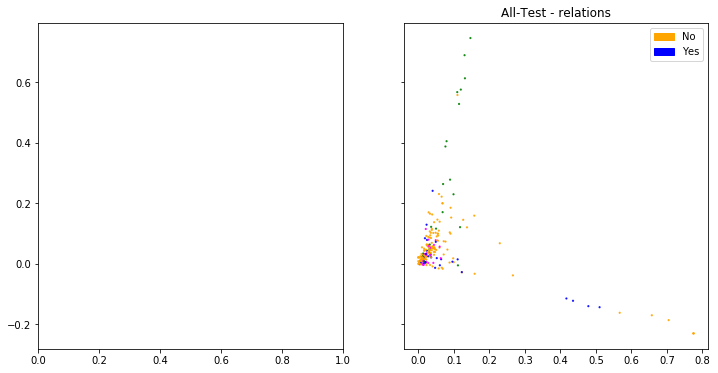

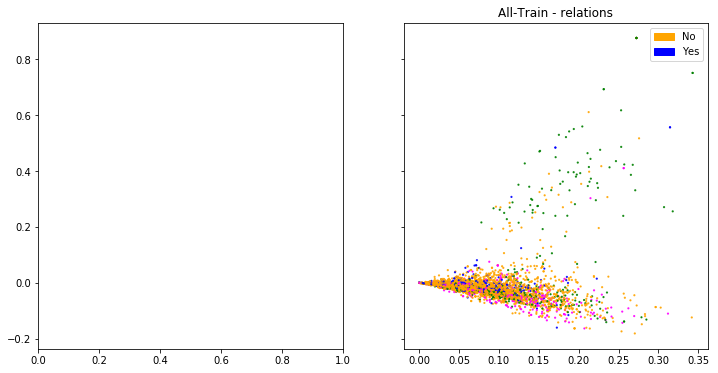

In [120]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for cat in dataframes.keys():

    df = dataframes[cat]
    labels = df['ActionName'].tolist()
    le.fit(labels)
    labels = le.transform(labels)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    
#     X_counts = vectorizer.fit_transform(df['text-neigh-tokens'])
#     plot_LSA(X_counts, labels, ax1)
#     ax1.set_title("{} - neighbours".format(cat))
    
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax2)
    ax2.set_title("{} - relations".format(cat))

In [33]:
'''
Now for the n-grams! 
Are there bigrams more interesting for the classifier than unigrams?
'''

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1, 3)
)

'''
Let's search for bigrams, which position are they,
if we also take unigrams into consideration?

(COUNT VECTORIZER)
'''

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    feature_count = 10 if 'Test' in cat else 100
    # because we expect nothing special from test dataset
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))
            
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))


>>> Other-Train

Model z relacjami:
bag-of-words: 10238
- NoOther
45. : command control, 19.0
57. : execut file, 16.0
60. : c&c server, 16.0
73. : download file, 13.0
76. : ip address, 13.0
82. : control server, 12.0
98. : command control server, 10.0
- Other
26. : post request, 22.0
43. : registri key, 16.0
49. : get request, 14.0
53. : http post, 13.0
62. : system-path system-path, 11.0
70. : http post request, 10.0
74. : pipe server, 9.0
78. : name pipe, 9.0
80. : dll modul, 8.0
97. : network share, 7.0
98. : http get request, 7.0
99. : http get, 7.0

Model 'sąsiedzi':
bag-of-words: 9447
- NoOther
26. : download execut, 22.0
58. : execut file, 13.0
64. : upload download, 12.0
87. : disk execut, 9.0
97. : download file, 9.0
- Other
49. : post request, 11.0
55. : registri key, 10.0
61. : get request, 9.0
68. : driver hook, 8.0
71. : http post, 8.0
81. : dll modul, 7.0
96. : usermod dll, 6.0
97. : load dll, 6.0

>>> File-Test

Model z relacjami:
bag-of-words: 844
- File
4. : event log

KeyboardInterrupt: 

In [15]:
'''
Check scores considering n-grams for TDIDF Vectorizer!
'''

vectorizer = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1,3)
)

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    feature_count = 10 if 'Test' in cat else 100
    # because we expect nothing special from test dataset
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))
            
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))


>>> ActionName-Train

Model z relacjami:
bag-of-words: 30775
- ActionName
47. : download file, 5.839672193343967
56. : execut file, 5.001764667127984
64. : post request, 4.601443536432968
69. : upload file, 4.3525977951713415
83. : command control, 3.727395518858263
92. : c&c server, 3.4038398288696743
- NoActionName
35. : c&c server, 9.282584717553169
41. : command control, 8.92652424556101
82. : attack use, 5.516364230587741
85. : ip address, 5.450388832132534

Model 'sąsiedzi':
bag-of-words: 25913
- ActionName
40. : download execut, 5.3181342086504815
88. : execut file, 3.164302576102987
92. : upload download, 3.049998721769038
- NoActionName
54. : c&c server, 6.728795838029409

>>> ActionName-Test

Model z relacjami:
bag-of-words: 2604
- ActionName
- NoActionName
4. : c&c server, 2.673775449766095

Model 'sąsiedzi':
bag-of-words: 2265
- ActionName
9. : download execut, 1.1457942846834346
- NoActionName
6. : c&c server, 1.9204115043608707

>>> Capability-Train

Model z relacjami:
b

In [64]:
dataframes['All-Train']

,Unnamed: 0,ActionName,Capability,token,text-rel-subj,text-rel,text-neigh,text-neigh-word-tokenized,text-neigh-processed,text-rel-word-tokenized,text-rel-processed,text-rel-subj-word-tokenized,text-rel-subj-processed,text-neigh-tokens,text-rel-tokens,text-rel-subj-tokens,label
0,0,-,Other,performs,ScanBox performs keylogging of users when they...,performs keylogging of users when they visit a...,on the game. ScanBox performs keylogging of us...,"[game, ., scanbox, perform, keylog, user]",game. scanbox perform keylog user,"[perform, keylog, user, visit, compromis, websit]",perform keylog user visit compromis websit,"[scanbox, perform, keylog, user, visit, compro...",scanbox perform keylog user visit compromis we...,"[game., scanbox, perform, keylog, user]","[perform, keylog, user, visit, compromis, websit]","[scanbox, perform, keylog, user, visit, compro...",Other
1,1,-,Other,perform,an attacker perform reconnaissance and key log...,perform reconnaissance and key logging of visi...,allows an attacker to perform reconnaissance a...,"[allow, attack, perform, reconnaiss, key, log]",allow attack perform reconnaiss key log,"[perform, reconnaiss, key, log, visitor, compr...",perform reconnaiss key log visitor compromis w...,"[attack, perform, reconnaiss, key, log, visito...",attack perform reconnaiss key log visitor comp...,"[allow, attack, perform, reconnaiss, key, log]","[perform, reconnaiss, key, log, visitor, compr...","[attack, perform, reconnaiss, key, log, visito...",Other
2,2,-,Other,tracking,tracking files and drives present on the victi...,tracking files and drives present on the victi...,a different method of tracking files and drive...,"[differ, method, track, file, drive, present]",differ method track file drive present,"[track, file, drive, present, victim, machin]",track file drive present victim machin,"[track, file, drive, present, victim, machin]",track file drive present victim machin,"[differ, method, track, file, drive, present]","[track, file, drive, present, victim, machin]","[track, file, drive, present, victim, machin]",Other
3,3,-,command_and_control,being,it being a command and control destination for...,being a command and control destination for ma...,also been observed as being a command and control,"[also, observ, command, control]",also observ command control,"[command, control, destin, malwar]",command control destin malwar,"[command, control, destin, malwar]",command control destin malwar,"[also, observ, command, control]","[command, control, destin, malwar]","[command, control, destin, malwar]",command_and_control
4,4,-,infection_propagation,contain,the e-mails contain links to websites hosting ...,contain links to websites hosting ScanBox,"victims, where the e-mails contain links to we...","[victim, e-mail, contain, link, websit, host]",victim e-mail contain link websit host,"[contain, link, websit, host, scanbox]",contain link websit host scanbox,"[e-mail, contain, link, websit, host, scanbox]",e-mail contain link websit host scanbox,"[victim, e-mail, contain, link, websit, host]","[contain, link, websit, host, scanbox]","[e-mail, contain, link, websit, host, scanbox]",infection_propagation
5,5,Network,Other,were dropped,Both backdoors were dropped from malicious doc...,Both backdoors were dropped from malicious doc...,and WATERSPOUT. Both backdoors were dropped fr...,"[waterspout, ., backdoor, drop, malici, docume...",waterspout. backdoor drop malici document built,"[backdoor, drop, malici, document, built, util...",backdoor drop malici document built util tran ...,"[backdoor, drop, malici, document, built, util...",backdoor drop malici document built util tran ...,"[waterspout., backdoor, drop, malici, document...","[backdoor, drop, malici, document, built, util...","[backdoor, drop, malici, document, built, util...",Other
6,6,-,Other,communicates,backdoor HTTP communicates via to a hard-coded...,HTTP communicates via to a hard-coded command ...,a proxy-aware backdoor that communicates via H...,

In [70]:
'''
Saving processed data to file
'''

subfolder = 'Processed'
for ccat in dataframes.keys():
    print(ccat)
    sub_path = os.getcwd() + "/Dataframes/All/" + subfolder
    new_filename = '{}-P.csv'.format(ccat)
    if "label" in dataframes[ccat].columns:
        dataframes[ccat].drop(["label"], axis=1)
    dataframes[ccat]['ActionName_num'] = dataframes[ccat]['ActionName'].map({'-':0, 'File':1, 'Network':2, 'Other':3})
    dataframes[ccat]['Capability_num'] = dataframes[ccat]['Capability'].map({'-':0, 'command_and_control':1, 'infection_propagation':2, 'Other':3})
    dataframes[ccat].to_csv(sub_path + "/" + new_filename)
    print("Saved ", sub_path + "/" + new_filename)


All-Test
Saved  /home/jells123/Documents/ENGINEER/Secure-NLP/Dataframes/All/Processed/All-Test-P.csv
All-Train
Saved  /home/jells123/Documents/ENGINEER/Secure-NLP/Dataframes/All/Processed/All-Train-P.csv


In [69]:
dataframes['All-Train'].drop('label', axis=1)
dataframes['All-Test'].drop('label', axis=1)

KeyError: "['label'] not found in axis"